In [1]:
import argparse
import numpy as np
from pprint import pprint
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torchvision import datasets, transforms
import os
from whitebox_utils import label_to_onehot, cross_entropy_for_onehot, pixelwise_euclidean_distance
import matplotlib.pyplot as plt

# 指定使用文泉驿微米黑（系统已识别的字体名称）
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  
# 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
tt = transforms.ToTensor()#转发为张量
tp = transforms.ToPILImage()#转换为图片


(-0.5, 383.5, 383.5, -0.5)

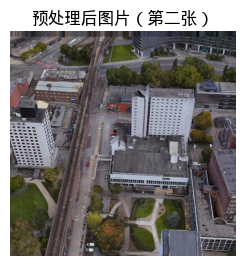

In [3]:
batchsize = 1
h, w = 384, 384
pad = 10

# 定义预处理流程
transform_list = [
    transforms.Resize((h, w), interpolation=3),
    transforms.Pad(pad, padding_mode='edge'),
    transforms.RandomCrop((h, w)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
data_transform = transforms.Compose(transform_list)

# 目标图片路径
target_path = '/mnt/workspace/RK-Net/data/University-Release/train/drone/0839'

# 验证路径是否存在
if not os.path.exists(target_path):
    raise FileNotFoundError(f"路径不存在: {target_path}")

# 加载指定路径下的图片
dataset = datasets.ImageFolder(
    root=os.path.dirname(target_path),
    transform=data_transform
)

# 过滤出目标子文件夹的样本
target_class = os.path.basename(target_path)
class_idx = dataset.class_to_idx[target_class]
filtered_indices = [i for i, (_, cls) in enumerate(dataset.imgs) if cls == class_idx]
dataset = torch.utils.data.Subset(dataset, filtered_indices)

# 检查图片数量是否足够
if len(dataset) < 2:
    raise ValueError(f"目标路径下照片数量不足2张，当前仅有{len(dataset)}张")

# 创建数据加载器
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batchsize,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 展示第二张照片（原始图片和预处理后图片）
# 1. 获取原始图片路径（未预处理）
# 注：dataset.imgs存储的是(图片路径, 类别)，需对应到过滤后的索引
original_img_path = dataset.dataset.imgs[filtered_indices[1]][0]  # 第二张图片的原始路径
original_img = Image.open(original_img_path).convert('RGB')  # 打开原始图片

# 2. 获取预处理后的图片（通过数据集索引获取）
preprocessed_img, label_image = dataset[3]  # 第二张图片（索引1）的预处理结果
# 转换为可显示格式（反归一化+转PIL）
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
preprocessed_img = inv_normalize(preprocessed_img)  # 反归一化
preprocessed_img = transforms.ToPILImage()(preprocessed_img)  # 转为PIL图片

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img)
plt.title('预处理后图片（第二张）')
plt.axis('off')

torch.Size([1, 3, 384, 384])


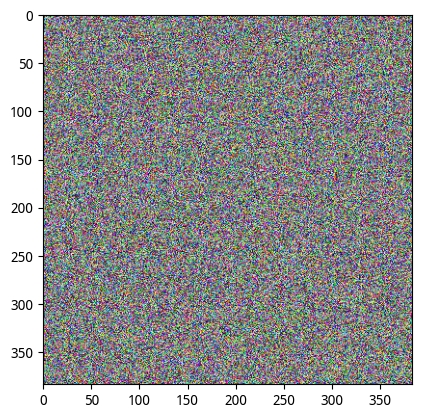

In [4]:

# 转换为batch格式（添加batch维度，模型通常需要[batch, c, h, w]格式）
preprocessed_img_torch = tt(preprocessed_img)
preprocessed_img_torch = preprocessed_img_torch.unsqueeze(0)  # 形状从[c, h, w]变为[1, c, h, w]
label_image_torch = torch.tensor([label_image])  # 标签添加batch维度

# 数据移至GPU（若使用）
print(preprocessed_img_torch.shape)
preprocessed_img = tp(preprocessed_img_torch[0])
dummy_data = torch.randn(*preprocessed_img_torch.size()).to(device).requires_grad_(True)  
dummy_label = torch.randn(label_image_torch.size()).to(device).requires_grad_(True)
plt.imshow(tp(dummy_data[0].cpu()))
plt.show()


In [5]:
from model_white_attack import ft_net
pretrained_path = '/mnt/workspace/RK-Net/RK-Net-main/model/pretrain/net_359.pth'  # 绝对路径
# RK-Net/RK-Net-main/model/pretrain/net_359.pth
model = ft_net(751).to(device)

# 加载预训练权重（strict=False允许部分参数不匹配，适用于迁移学习）
pretrained_state = torch.load(pretrained_path, map_location=torch.device('cpu'))
model.load_state_dict(pretrained_state, strict=False)
print("Loaded pretrained model from:", pretrained_path)

/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained model from: /mnt/workspace/RK-Net/RK-Net-main/model/pretrain/net_359.pth


| 索引 | 模块名称                          | 说明                          |
|------|-----------------------------------|-------------------------------|
| 0    | `model_ft.conv1`                  | 第1层：初始卷积层             |
| 1    | `model_ft.bn1`                    | 第2层：批归一化层             |
| 2    | `model_ft.relu`                   | 第3层：ReLU激活函数           |
| 3    | `self.usam_1`                     | 第4层：USAM注意力模块（第一个）|
| 4    | `model_ft.maxpool`                | 第5层：最大池化层             |
| 5    | `model_ft.layer1`                 | 第6层：ResNet第1个残差块      |
| 6    | `self.usam_2`                     | 第7层：USAM注意力模块（第二个）|
| 7    | `model_ft.layer2`                 | 第8层：ResNet第2个残差块      |
| 8    | `model_ft.layer3`                 | 第9层：ResNet第3个残差块      |
| 9    | `model_ft.layer4`                 | 第10层：ResNet第4个残差块     |
| 10   | `model_ft.avgpool2`               | 第11层：全局平均池化层        |
| 11   | `lambda x: x.view(x.size(0), x.size(1))` | 第12层：特征展平操作（将空间维度展平为特征向量） |
sp为f[:sp],g[sp:],逻辑为前闭后开,1为conv1与bn1之间分割

In [6]:
print(dummy_data.size())
print(dummy_label)
# 总变差函数,输入dummy图像
def _tensor_size(t):
    return t.size()[1]*t.size()[2]*t.size()[3]
def total_variation(x):
    batch_size = x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]
    count_h = _tensor_size(x[:,:,1:,:])
    count_w = _tensor_size(x[:,:,:,1:])
    h_tv = torch.pow(x[:,:,1:,:]-x[:,:,:h_x-1,:], 2).sum()
    w_tv = torch.pow(x[:,:,:,1:]-x[:,:,:,:w_x-1], 2).sum()
    return (h_tv / count_h + w_tv / count_w) / batch_size

# def loss_function_1(X_cut, X0_cut,tv, lambda_param=0.4):

#     euclidean_dist = pixelwise_euclidean_distance(X_cut, X0_cut)
    
#     return euclidean_dist + lambda_param * tv

torch.Size([1, 3, 384, 384])
tensor([0.3801], device='cuda:0', requires_grad=True)


In [7]:
#optimizer.zero_grad()  # 清空梯度
torch.manual_seed(1234)
print(dummy_data.shape)
print(preprocessed_img_torch.shape)
preprocessed_img_torch = preprocessed_img_torch.to(device)
dummy_data = dummy_data.to(device)
# compute original gradient 
# _, original_cut = model(preprocessed_img_torch)
original_cut = model.f(preprocessed_img_torch)
ture_cut= original_cut.detach().clone()
#print(original_cut)
# original_loss = criterion(pred, gt_onehot_label)
# dy_dx = torch.autograd.grad(original_loss, net.parameters(), retain_graph=True)

#original_dy_dx = list((_.detach().clone() for _ in dy_dx))


torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])


In [8]:
print(original_cut.shape)

torch.Size([1, 256, 96, 96])


epoch is 0, and loss is 383.0888671875 loss_1: 505.14544677734375 loss_2: 166.2660369873047, diff_cut: 382.37750244140625
epoch is 2000, and loss is 82.29131317138672 loss_1: 513.749755859375 loss_2: 21.130212783813477, diff_cut: 81.71575927734375
epoch is 4000, and loss is 59.34048843383789 loss_1: 512.570068359375 loss_2: 14.43801498413086, diff_cut: 58.77170944213867
epoch is 6000, and loss is 51.62715148925781 loss_1: 513.9506225585938 loss_2: 12.331069946289062, diff_cut: 51.05768585205078
epoch is 8000, and loss is 47.677127838134766 loss_1: 515.641357421875 loss_2: 11.492109298706055, diff_cut: 47.10572814941406
epoch is 10000, and loss is 44.97013473510742 loss_1: 516.791748046875 loss_2: 10.873062133789062, diff_cut: 44.39741134643555
epoch is 12000, and loss is 42.969749450683594 loss_1: 517.3091430664062 loss_2: 10.305889129638672, diff_cut: 42.39650344848633
epoch is 14000, and loss is 41.57791519165039 loss_1: 517.5121459960938 loss_2: 9.969076156616211, diff_cut: 41.00438

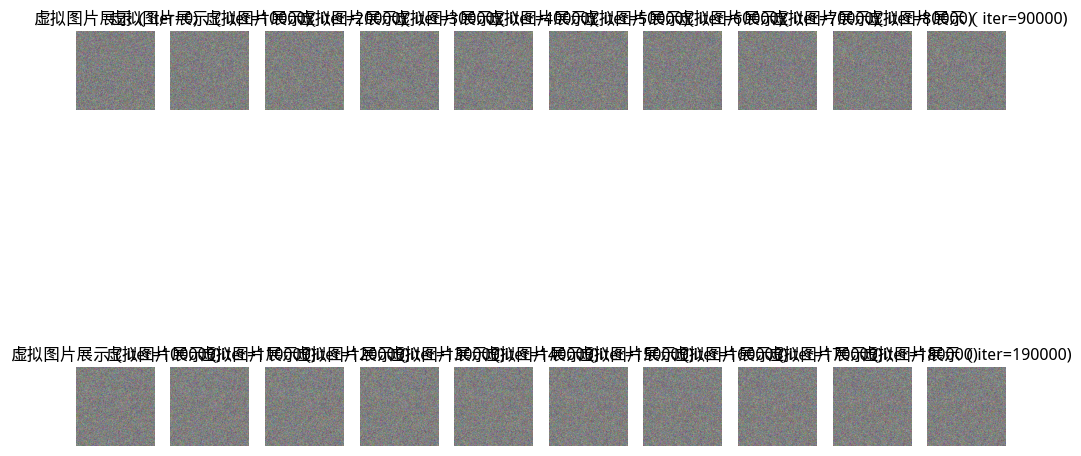

In [9]:
T = 40000
lr = 0.001
optimizer = torch.optim.Adam([dummy_data], lr=lr)
# range_T = tqdm(range(1, T+1), desc="White-box attacking...")
epsilon=1e-6
l0 = 1e-3
l1 = 0.01
l2 = 1e-3
history = []


for iters in range(T):
    optimizer.zero_grad()  # 清空梯度
        # 使用网络对虚拟数据进行预测
    # _, dummy_cut = model(dummy_data)
    dummy_cut = model.f(dummy_data)
    tv = total_variation(dummy_data)
    diff_cut = torch.norm((dummy_cut[ture_cut.abs()>epsilon]- ture_cut[ture_cut.abs()>epsilon]), p=2)
    loss_1 = torch.norm(dummy_data-torch.clamp(dummy_data, min=0, max=1))
    loss_2 = torch.norm(dummy_cut[ture_cut.abs()<epsilon])
    dummy_loss = diff_cut +tv*l1+l0*loss_1 + l0*loss_2
        
        #dummy_dcut_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True, retain_graph=True, allow_unused=True)
    dummy_loss.backward()
    optimizer.step()  # 进行dummy_data参数更新
    #dummy_loss, dummy_dcut_dx = closure()
   
    if iters % 2000 == 0: ##打印损失
        print(f"epoch is {iters}, and loss is {dummy_loss} loss_1: {loss_1} loss_2: {loss_2}, diff_cut: {diff_cut}")
        #print(iters, "%.4f" % current_loss.item())
        history.append(tp(dummy_data[0].cpu()))
        
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(history[i])
    plt.title("虚拟图片展示（iter=%d)" % (i * 10000))
    plt.axis('off')

plt.show()


In [10]:
# print(dummy_loss)